**Simulated Annealing for the predator-prey model**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import warnings


from scipy.optimize import minimize
import scipy.stats as stat

In [3]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df

In [4]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    '''Defines the Lotka Volterra equations for the predator prey model. 
    init = initial conditions for the model (x0,y0)
    t = list of time points at which funciton is analyzed (needed for odeint)
    alpha, beta, delta, gamma = model parameters
    Returns the value of dx/dt and dy/dt'''
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    '''First minimization function, calculates the residual based on the squared normalized
    difference between the given data points and the model output for a given set of params'''
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]
    
    warnings.filterwarnings("ignore")
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    '''Second minimization function, calculates the residual based on sum of the squared differences
    between each point in the data output and each point calculated with the model parameters'''
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    
    warnings.filterwarnings("ignore")
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))
    
    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss * 1/(2*len(x))

In [5]:
def simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (array of real numbers, indicating alpha, beta, delta, gamma, x0 and y0)
    n_iterations = number of iterations to be performed
    std = standard deviation of the normal distribution that determines new possible solutions (step size)
    min_function = objective function (to be minimized)
    T_start = starting temperature for the cooling schedule
    a, b = variables for the cooling schedule
    data = the data to be fitted

    Returns the final solution and the fitness value of that solution
    """

    prev_sol = init_guess
    T = T_start
    
    for n in range(n_iterations):
        # create a new solution
        new_sol = prev_sol + np.random.normal(0, step, size=len(prev_sol))

        # determine whether new_sol is accepted 
        u = np.random.uniform()

        fit_new_sol = min_function(new_sol,data)
        fit_prev_sol = min_function(prev_sol,data)

        # use Boltzman distribution
        if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1): 
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)

    return prev_sol, min_function(prev_sol,data)

In [6]:
def hill_climber(initial_params, iterations, step_size, data):
    best_params = initial_params
    prev_params = best_params*2
    best_loss = loss_function_res(initial_params, data)
    
    while best_params.any != prev_params.any:
        prev_params = best_params
        for i in range(iterations):
            init_par = initial_params
            # Generate a random perturbation to the parameters
            new_params = init_par + np.random.normal(0,step_size,4)
        
            # Calculate the loss for the new parameters
            new_loss = loss_function_res(new_params, data)
            
            # Update if the new parameters give a better loss
            if new_loss < best_loss:
                best_loss = new_loss
                best_params = new_params
    
    return best_params, best_loss

In [7]:
def plot_fit(params, df):
    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    y0 = [x[0], y[0]]
     
    time = np.array(df['t'])
    t = np.linspace(time[0], time[-1], 1000)

    output = odeint(lotka_volterra, y0, t, args=(alpha, beta, delta, gamma))

    # Prey population separate
    plt.plot(t,output[:,0], color="r", label = 'Prey')
    plt.scatter(df["t"], df["x"], color = 'r', s = 5)

    plt.legend(fontsize = 15, loc = 'upper right')
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()

    # Predator population separate
    plt.plot(t,output[:,1], color="b", label = 'Predator')
    plt.scatter(df["t"], df["y"], color = 'b', s = 5)

    plt.legend(fontsize = 15, loc = 'upper right')
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()

    # Both populations together

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'Prey')
    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'Predator')
    
    plt.legend(fontsize = 15)
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()


In [45]:
np.random.seed(8)

init_guess = np.random.uniform(-1,1,4)
n_iterations = 13000
std = 0.5
min_function = abs_residual
T_start = 20
a = 3
b = 10

params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8351404250964D+01   r2 =  0.7525886899946D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8351404250964D+01   r2 =  0.7525886899946D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8903734639890D+01   r2 =  0.7329866251732D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8903734639890D+01   r2 =  0.7329866251732D-15
 lsoda--  warning..internal t (=r1) 

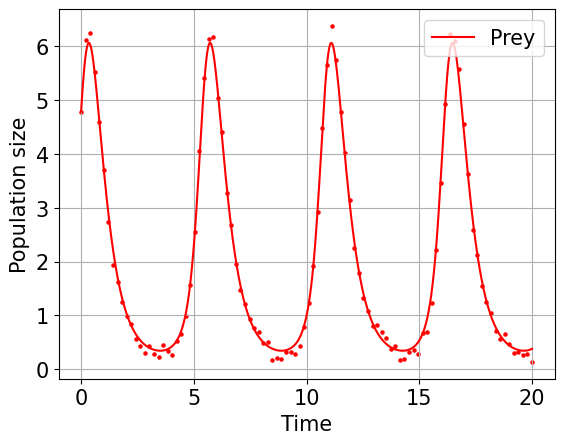

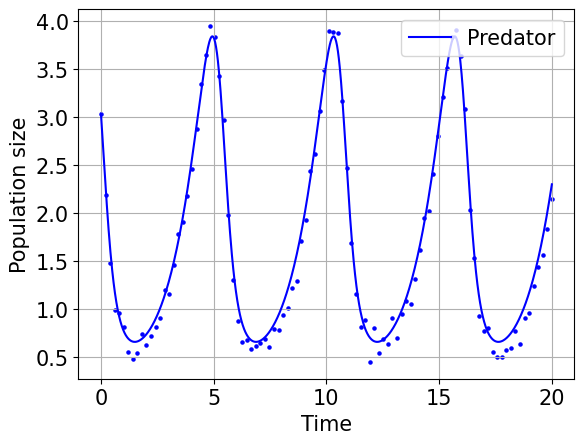

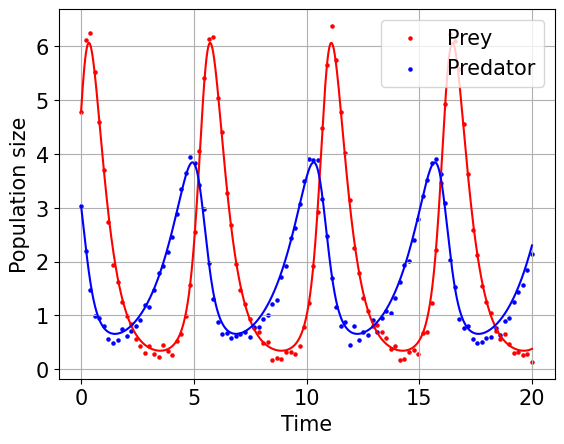

[-2.04697827 -1.13576891 -0.41375364 -0.82398556]
0.030575783460947994


In [47]:
plot_fit(params, df)
print(params)
print(loss_function_res(params,df))

In [8]:
def multi_runs(runs, n_iterations, step, min_function, optimization_technique, parameters, data):
    """
    Runs the simulated annealing algorithm multiple times, with random initial guess.
    Returns:
    err_temp = list of all errors (determined with min_function)
    best_sol = solution with lowest residual over all runs
    err_best = residual of best solution
    """
    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(-1,1,4)

        if optimization_technique == 'HC':
            neighbors = parameters
            params, err = hill_climber(init_guess, neighbors, step, data)

        if optimization_technique == 'SA':
            T_start, a, b = parameters
            params, err = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data)

        err_temp.append(err)

        if err < float('inf'):
            best_sol = params
            err_best = err
    return err_temp, best_sol, err_best

In [9]:
def step_sizes(step_range, runs, n_iterations, min_function, optimization_technique, parameters, data):
    err_list = []
    std_list = []
    err_temp_list = []
    best_err_so_far = float('inf')

    for step in step_range:
        print(optimization_technique, step)

        err_temp, best_sol, err_best = multi_runs(runs, n_iterations, step, min_function, optimization_technique, parameters, data)
        err_temp_list.append(err_temp)
        
        # save overall best solution and its step size
        if err_best < best_err_so_far:
            best_err_so_far = err_best
            best_sol_total = best_sol

        err_list.append(np.mean(err_temp))
        std_list.append(np.std(err_temp))

    return err_list, std_list, best_sol_total, err_temp_list

In [10]:
n_iterations = 1300
min_function = loss_function_res
T_start = 2
a = 3
b = 10
parameters = [T_start, a, b]
data = df

step_range = np.arange(0.1,2,0.2)
runs = 15

err_SA, std_SA, best_SA, err_temp_SA = step_sizes(step_range, runs, n_iterations, min_function, 'SA', parameters, data)

SA 0.1
SA 0.30000000000000004
SA 0.5000000000000001
SA 0.7000000000000001
SA 0.9000000000000001
SA 1.1000000000000003
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1107127235485D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1085038904688D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1102745480550D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1654983620379D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1145223701341D+02   r2 =         

In [11]:
print(err_SA)

[4.6934870320293545, 4.463541322322829, 4.281043978607059, 5.284725069732246, 4.801043550998205, 5.136267432747335, 5.100424024910898, 5.4365198206816325, 5.066937470947207, 4.829478072639051]


In [12]:
parameters = 30
runs = 60
err_HC, std_HC, best_HC, err_temp_HC = step_sizes(step_range, runs, n_iterations, min_function, 'HC', parameters, data)

HC 0.1
HC 0.30000000000000004
HC 0.5000000000000001
HC 0.7000000000000001
HC 0.9000000000000001
HC 1.1000000000000003
HC 1.3000000000000003
HC 1.5000000000000004
HC 1.7000000000000004
HC 1.9000000000000004


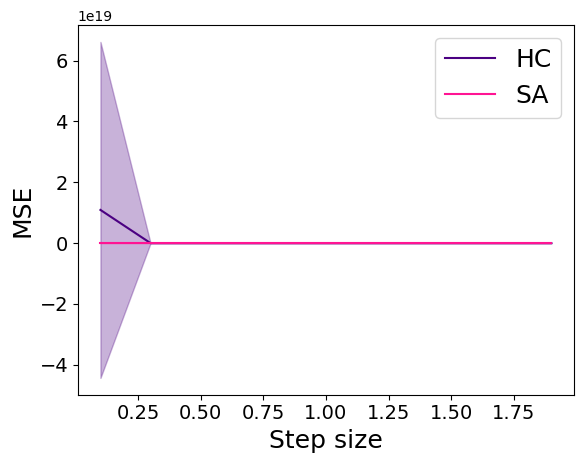

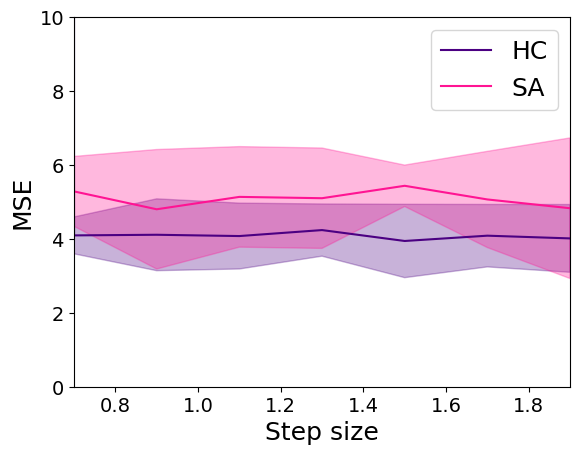

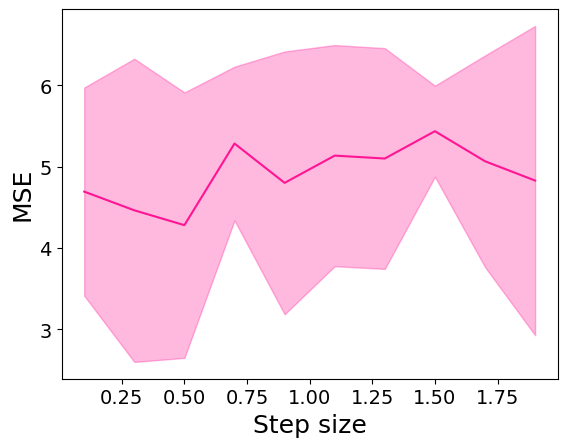

In [35]:
plt.plot(step_range, err_HC, color = 'indigo', label = 'HC')
plt.fill_between(step_range, np.array(err_HC)-np.array(std_HC), np.array(err_HC)+np.array(std_HC), color = 'indigo', alpha = 0.3)

plt.plot(step_range, err_SA, color = 'deeppink', label = 'SA')
plt.fill_between(step_range, np.array(err_SA)-np.array(std_SA), np.array(err_SA)+np.array(std_SA), color = 'deeppink', alpha = 0.3)

plt.xlabel('Step size', fontsize = 18)
plt.ylabel('MSE', fontsize = 18)
plt.tick_params(labelsize = 14)
plt.legend(fontsize = 18)
plt.show()

plt.plot(step_range, err_HC, color = 'indigo', label = 'HC')
plt.fill_between(step_range, np.array(err_HC)-np.array(std_HC), np.array(err_HC)+np.array(std_HC), color = 'indigo', alpha = 0.3)

plt.plot(step_range, err_SA, color = 'deeppink', label = 'SA')
plt.fill_between(step_range, np.array(err_SA)-np.array(std_SA), np.array(err_SA)+np.array(std_SA), color = 'deeppink', alpha = 0.3)

plt.xlabel('Step size', fontsize = 18)
plt.ylabel('MSE', fontsize = 18)
plt.tick_params(labelsize = 14)
plt.legend(fontsize = 18)
plt.xlim(0.7,1.9)
plt.ylim(0,10)
plt.show()

plt.plot(step_range, err_SA, color = 'deeppink', label = 'SA')
plt.fill_between(step_range, np.array(err_SA)-np.array(std_SA), np.array(err_SA)+np.array(std_SA), color = 'deeppink', alpha = 0.3)

plt.xlabel('Step size', fontsize = 18)
plt.ylabel('MSE', fontsize = 18)
plt.tick_params(labelsize = 14)
# plt.legend(fontsize = 18)
plt.show()


Hill Climber:
parameters:  [-1.71042766 -1.03440746 -0.6999773  -1.16425934]
error:  1.0555480204949357


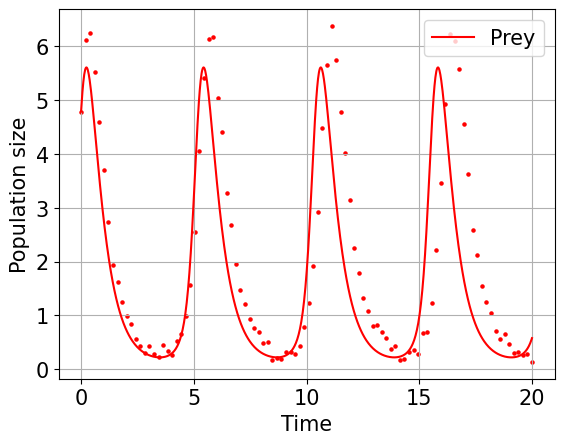

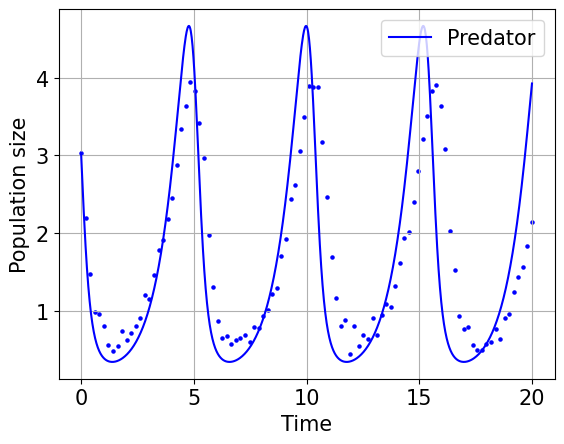

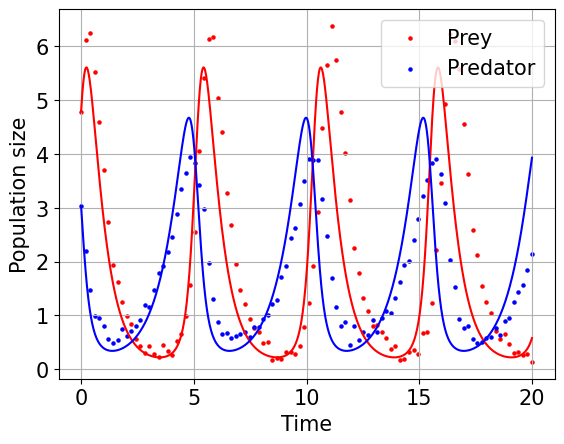

Simulated annealing
parameters:  [-0.70955353 -2.39139583 -4.41955891 -8.68491914]
error:  1.6743868319426085


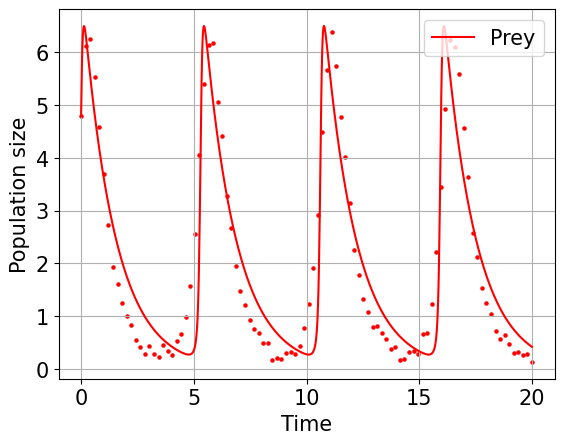

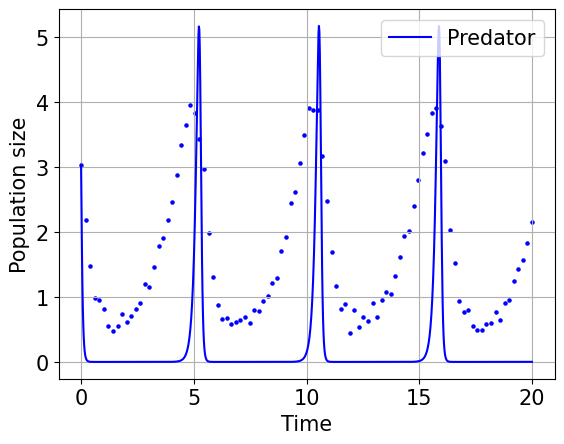

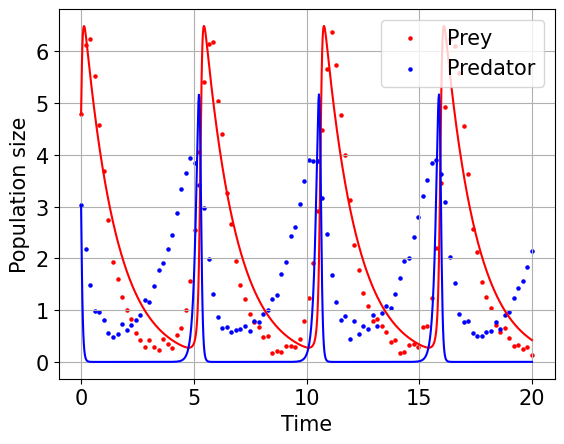

In [16]:
print('Hill Climber:')
print('parameters: ', best_HC)
print('error: ', loss_function_res(best_HC, data))
plot_fit(best_HC, data)
print('Simulated annealing')
print('parameters: ', best_SA)
print('error: ', loss_function_res(best_SA, data))
plot_fit(best_SA, data)

**Statistical testing**

Test HC/SA

In [24]:
def welchs_test(waiting_times_1, waiting_times_2):
    test = stat.ttest_ind(waiting_times_1,waiting_times_2, equal_var=False)
    statistic = test.statistic
    pvalue = test.pvalue
    df = test.df
    return statistic, pvalue, df

In [21]:
print(err_temp_SA[1])

[5.1773186663436634, 6.981813636336768, 4.973818363834435, 4.467896776455751, 5.7164530728900775, 3.803797653619556, 1.6286294872742613, 5.714814654841556, 1.2057744299261868, 5.656520339109947, 0.5016986801681314, 6.63130843797919, 4.668108732171701, 5.439965855180365, 4.38520104871086]


In [31]:
for i in range(len(step_range)):
    statist, p, df = welchs_test(err_temp_HC[i], err_temp_SA[i])
    print(f'For step = {round(step_range[i],1)} stat = {statist}, p = {p}, df = {df}')

For step = 0.1 stat = 1.5181823911121357, p = 0.13430905815940034, df = 59.0
For step = 0.3 stat = 1.1476671347840997, p = 0.25567746515319495, df = 59.790143670933695
For step = 0.5 stat = 1.0000022926090975, p = 0.3213931796184898, df = 59.00000000037331
For step = 0.7 stat = -4.563544678418014, p = 0.0003240655242083027, df = 15.892655879043101
For step = 0.9 stat = -1.532059562189585, p = 0.14448219273686333, df = 16.476670245562982
For step = 1.1 stat = -2.777605247416453, p = 0.012922278187702578, df = 16.954153666661362
For step = 1.3 stat = -2.303694709211403, p = 0.03513726865253175, df = 15.840630047161023
For step = 1.5 stat = -7.553401640999727, p = 4.688989612211247e-09, df = 37.6750517097579
For step = 1.7 stat = -2.6873056952972707, p = 0.015639711197776095, df = 16.89913767995233
For step = 1.9 stat = -1.5639257831107087, p = 0.1379225031956602, df = 15.575602695627156


Test within SA

In [32]:
max_SA_index = np.where(err_SA == np.max(err_SA))[0][0]
min_SA_index = np.where(err_SA == np.min(err_SA))[0][0]

max_HC_index = np.where(err_HC == np.max(err_HC))[0][0]
min_HC_index = np.where(err_HC == np.min(err_HC))[0][0]

In [33]:
stat_SA, p_SA, df_SA = welchs_test(err_temp_SA[max_SA_index], err_temp_SA[min_SA_index])
stat_HC, p_HC, df_HC = welchs_test(err_temp_HC[max_HC_index], err_temp_HC[min_HC_index])

print(f'For SA step = {round(step_range[max_SA_index],1)} and step = {round(step_range[min_SA_index],1)}: stat = {stat_SA}, p = {p_SA}, df = {df_SA}')
print(f'For HC step = {round(step_range[max_HC_index],1)} and step = {round(step_range[min_HC_index],1)}: stat = {stat_HC}, p = {p_HC}, df = {df_HC}')

For SA step = 1.5 and step = 0.5: stat = 2.504994204702287, p = 0.022548307886069444, df = 17.24908223934327
For HC step = 0.1 and step = 1.5: stat = 1.5181823911121357, p = 0.13430905815940034, df = 59.0


## Time series

### functions

In [33]:
from scipy.optimize import minimize
# Objective functions

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]       
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t_data)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

def minimise_loss_function_res(df, params0=None):
    if params0 is None:
        params0 = np.array([-1, -0.5, -0.5, -2])
    output_minimise = minimize(loss_function_res, params0, args=(df))
    # fitted_parameters = output_minimise.x
    # loss = output_minimise.fun
    return output_minimise

def plot_lotka(df, fitted_parameters, extra_df=None):
    t = np.array(df['t'], dtype=float)
    x = np.array(df['x'], dtype=float)
    y = np.array(df['y'], dtype=float)
    alpha_fit, beta_fit, delta_fit, gamma_fit = fitted_parameters
    y0 = [x[0], y[0]]
    t = np.linspace(t[0], t[-1], num=len(t))
    output = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

    plt.title("Preditor-Prey Dynamics")
    plt.ylabel("Population size")
    plt.xlabel("Time")
    plt.grid()

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["x"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()

    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')
    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["y"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()


# Time series
def remove_random_rows(df, percentage):
    '''
    Percentage as decimal number.
    '''
    # Number of rows to remove
    remove_n = int(len(df) * percentage)

    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    return df.drop(drop_indices)

def remove_last(df, percentage):
    index_to_keep = int(len(df) * percentage)
    return df.iloc[:index_to_keep]

def filter_df(df, column, lower, upper):
    return df[~df[column].between(lower, upper)]


def multi_run_remove_rows(df, n_runs, optimization_algorithm='No'):
    dict_percentage_loss = {}
    for percentage in range(0,50,10):
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_random_rows(df, percentage/100)

            # Get optimal parameters for this subset
            if optimization_algorithm == 'No':
                params = minimise_loss_function_res(df_subset).x
            if optimization_algorithm == 'SA':
                init_guess = np.random.uniform(-1,1,4)
                n_iterations =  1000
                step = 1.1
                min_function = loss_function_res
                T_start = 2
                a =  3
                b =  10
                params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df)[0]

            # calculate the loss for the parameters for the original data points
            loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss

def plot_dict(dict):
    keys = np.array(list(dict.keys()))
    values = np.array(list(dict.values()))
    # means = np.mean(values, axis=1)
    # stds = np.std(values, axis=1)
    means = []
    lower = []
    upper = []

    for value in values:
        mean = np.mean(value)
        ci =stat.t.interval(confidence=0.95, df=len(value)-1, loc=mean, scale=stat.sem(value))
        means.append(mean)
        lower.append(ci[0])
        upper.append(ci[1])

    plt.plot(keys, means)
    plt.fill_between(keys, np.array(lower), np.array(upper), alpha=0.3)
    plt.xlabel('percentage removed')
    plt.ylabel('loss')
    plt.show()


In [39]:
np.random.seed(3)

import warnings
# Ignore the ODEintWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.integrate._odepack")

df = pd.read_csv("predator-prey-data.csv", delimiter = ",")

dict = multi_run_remove_rows(df, 10, optimization_algorithm='No')

percentage: 0: run 0
percentage: 0: run 1
percentage: 0: run 2
percentage: 0: run 3
percentage: 0: run 4
percentage: 0: run 5
percentage: 0: run 6
percentage: 0: run 7
percentage: 0: run 8
percentage: 0: run 9
percentage: 10: run 0
percentage: 10: run 1
percentage: 10: run 2
percentage: 10: run 3
percentage: 10: run 4
percentage: 10: run 5
percentage: 10: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

percentage: 10: run 7
percentage: 10: run 8
percentage: 10: run 9
percentage: 20: run 0
percentage: 20: run 1
percentage: 20: run 2
percentage: 20: run 3
percentage: 20: run 4
percentage: 20: run 5
percentage: 20: run 6
percentage: 20: run 7
percentage: 20: run 8
percentage: 20: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 0
percentage: 30: run 1
percentage: 30: run 2
percentage: 30: run 3
percentage: 30: run 4
percentage: 30: run 5
percentage: 30: run 6
percentage: 30: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

percentage: 30: run 8
percentage: 30: run 9
percentage: 40: run 0
percentage: 40: run 1
percentage: 40: run 2
percentage: 40: run 3
percentage: 40: run 4
percentage: 40: run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

percentage: 40: run 6
percentage: 40: run 7
percentage: 40: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 9


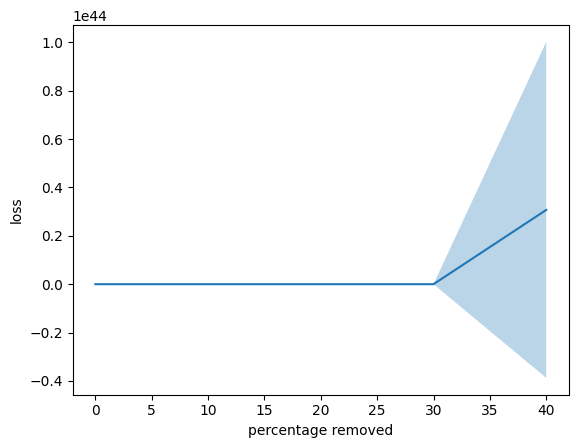

In [40]:
plot_dict(dict)